# MS Data Science & Society: Thesis Code File

This python notebook file contains the code for the thesis "Predicting Trust in Police in African Countries: Using Machine Learning Methods and Error Visualization Techniques", submitted in partial fulfillment of the requirements for the degree of master of Data Science & Society at the School of Humanities and Digital Sciences of Tilburg University. 


# Pre-Processing

In this ipynb file two versions of this dataset are loaded: One with data as categorical factors (for LR and MLP), and one with the data label encoded (for RF and XGBoost). Pre-processing has been performed using R.   <br>

The binary target classes are balanced, at 50.4% vs 49.6%. 

### Import packages

In [131]:
# Install the following packages in environment:
    # os
    # pandas
    # numpy 
    # csv 
    # (ipykernel)
    # seaborn
    # matplotlib 
    # pyreadstat
    # scikit-learn
    # tensorflow
    # xgboost (conda-force)
    # scikeras (pip)
    # shap (pip)


# Standard library imports
import os
import timeit

# Import libraries for data processing and visualization
import csv
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadstat
import scipy.stats as ss
import seaborn as sns
import shap

# Import machine learning libraries
import tensorflow
import xgboost as xgb

# Import machine learning modules
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential 
from xgboost import XGBClassifier

# Import scikit-learn modules
from scikeras.wrappers import KerasClassifier # to use sklearn with Keras (wrap Keras models)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import OneHotEncoder

# Other modules
from matplotlib import rcParams


### Specify two feature subsets 

In [190]:
# Specify the names of the variables in both feature subsets

# Feature Subset 1 (Demographic / Objective)
variable_names_subset_1 = ['COUNTRY', 'URBRUR', 'REGION', 'EA_SVC_A', 'EA_SVC_B', 'EA_SVC_C', 'EA_SVC_D', 'EA_SVC_E', 
                  'EA_FAC_A', 'EA_FAC_B', 'EA_FAC_C', 'EA_FAC_D', 'EA_FAC_E', 'EA_FAC_F', 'EA_FAC_G', 'EA_SEC_A',
                  'EA_SEC_B', 'EA_SEC_C', 'EA_SEC_D', 'EA_SEC_E', 'EA_ROAD_A', 'EA_ROAD_B', 'EA_ROAD_C', 
                  'PREVINT', 'THISINT', 'Q1', 'Q2', 'Q4B', 'Q81', 'Q92E', 'Q93B', 'Q94A', 'Q94B', 'Q94C', 
                  'Q94D', 'Q95A', 'Q95B', 'Q95C', 'Q95D', 'Q97', 'Q98A', 'Q101', 'Q102', 'Q104', ]

print("Variable labels subset 1:", variable_names_subset_1, "\n")


# name variable labels
variable_labels_subset_1 = ['Country', 'Urban / Rural', 'Region', 'Electricity Grid in PSA/EA', 'Piped Water System in PSA/EA', 
                            'Sewage System in PSA/EA', 'Phone Service in PSA/EA', 'Boreholl or Tubewell in PSA/EA', 'Post Office in PSA/EA', 'School in PSA/EA', 'Police Station in PSU/EA', 'Health Clinic in PSU/EA', 'Market Stalls in PSU/EA', 'Bank in PSU/EA', 'Paid Transport in PSA/EA', 'Police in PSA/EA', 'Soldiers/Army in PSA/EA', 'Roadblocks in PSA/EA', 'Custom Checkpoints in PSU/EA', 'Roadblocks in PSU/EA', 'Road Surface Start', 'Road Surface End', 'Road Condition End', 'Gender Previous Interview', 'Gender This Interview', 'Age', 'Home Language', 'Living Conditions', 'Ethnic Community/ Tribe', 'Own Bank Account', 'Location Toilet', 'Electric Connection (Mains)', 'Electricity Available (Mains)', 'Other Source Electricity Available', 'Other Source Electricity: Type', 'Employment Status', 'Pay Income Tax Required', 'Occupation', 'Employer', 'Education', 'Religion', 'Gender', 'Race', 'Type of Shelter']

# Create a dictionary mapping variable names to labels
variable_names_dict = dict(zip(variable_names_subset_1, variable_labels_subset_1))

first5pairs = {k: variable_names_dict[k] for k in list(variable_names_dict)[:5]}
print("Variable dictionary first 5 pairs:", first5pairs, "\n")

# Feature Subset 2 (Perceptions / Opinion Questions)
# variables to exclude: use 'df_.drop(columns=exclude_variables)'
exclude_variables = variable_names_subset_1 + ['trust_police', 'Q41G', 'COUNTRY.old.spelling', 'COUNTRY_R7List', 'COUNTRY_R6List', 'COUNTRY_R5List', ] # actually more !!!!

# print the list
# print("Variables to exclude subset 2:", exclude_variables)


Variable labels subset 1: ['COUNTRY', 'URBRUR', 'REGION', 'EA_SVC_A', 'EA_SVC_B', 'EA_SVC_C', 'EA_SVC_D', 'EA_SVC_E', 'EA_FAC_A', 'EA_FAC_B', 'EA_FAC_C', 'EA_FAC_D', 'EA_FAC_E', 'EA_FAC_F', 'EA_FAC_G', 'EA_SEC_A', 'EA_SEC_B', 'EA_SEC_C', 'EA_SEC_D', 'EA_SEC_E', 'EA_ROAD_A', 'EA_ROAD_B', 'EA_ROAD_C', 'PREVINT', 'THISINT', 'Q1', 'Q2', 'Q4B', 'Q81', 'Q92E', 'Q93B', 'Q94A', 'Q94B', 'Q94C', 'Q94D', 'Q95A', 'Q95B', 'Q95C', 'Q95D', 'Q97', 'Q98A', 'Q101', 'Q102', 'Q104'] 

Variable dictionary first 5 pairs: {'COUNTRY': 'Country', 'URBRUR': 'Urban / Rural', 'REGION': 'Region', 'EA_SVC_A': 'Electricity Grid in PSA/EA', 'EA_SVC_B': 'Piped Water System in PSA/EA'} 



### Dataframe 1: One-Hot Encoded

* For Logistic Regression and Multi-Layer Perceptron Models

#### Load dataset

In [191]:
# Load categorical (factor) dataset

# file path to dataset from current directory 
## for local computer:
csv_file_path_factors = "./afrobaro_dataset/afrobaro_as_factors_2.csv"
## for uni gpu shell:
#csv_file_path_factors = "./afrobaro_as_factors_2.csv"

# read the CSV file into a DataFrame
df_as_factors = pd.read_csv(csv_file_path_factors)

# see df
print(df_as_factors.head())

/var/folders/d_/5prlcz8x4pb52bq7r_l_ppf40000gn/T/ipykernel_10983/4088798451.py:10: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_as_factors = pd.read_csv(csv_file_path_factors)


  COUNTRY COUNTRY.old.spelling COUNTRY_R7List COUNTRY_R6List COUNTRY_R5List  \
0  Angola               Angola         Angola         Angola         Angola   
1  Angola               Angola         Angola         Angola         Angola   
2  Angola               Angola         Angola         Angola         Angola   
3  Angola               Angola         Angola         Angola         Angola   
4  Angola               Angola         Angola         Angola         Angola   

  URBRUR       URBRUR_COND  REGION EA_SVC_A EA_SVC_B  ...  R8part AGE_v1  \
0  Urban  Urban/Semi-urban  Luanda      Yes      Yes  ...  Part 1  26-35   
1  Urban  Urban/Semi-urban  Luanda      Yes       No  ...  Part 1  18-25   
2  Urban  Urban/Semi-urban  Luanda      Yes       No  ...  Part 1  18-25   
3  Urban  Urban/Semi-urban  Luanda      Yes       No  ...  Part 1  18-25   
4  Urban  Urban/Semi-urban  Luanda      Yes       No  ...  Part 1  26-35   

  AGE_v1.1 AGE_v2_UN AGE_v2.1_UN AGE_v3_AU AGE_v4 AGE_v5 AGE_v6 trus

In [194]:
# Print target column
print(df_as_factors['trust_police'])
# 0 = no trust in police     i.e. 'not at all' and 'just a little'
# 1 = trust in police        i.e. 'somewhat' and 'a lot'

0        0
1        0
2        0
3        0
4        0
        ..
47301    0
47302    0
47303    0
47304    1
47305    1
Name: trust_police, Length: 47306, dtype: int64


#### (Heatmap of Cramer's V Correlations)

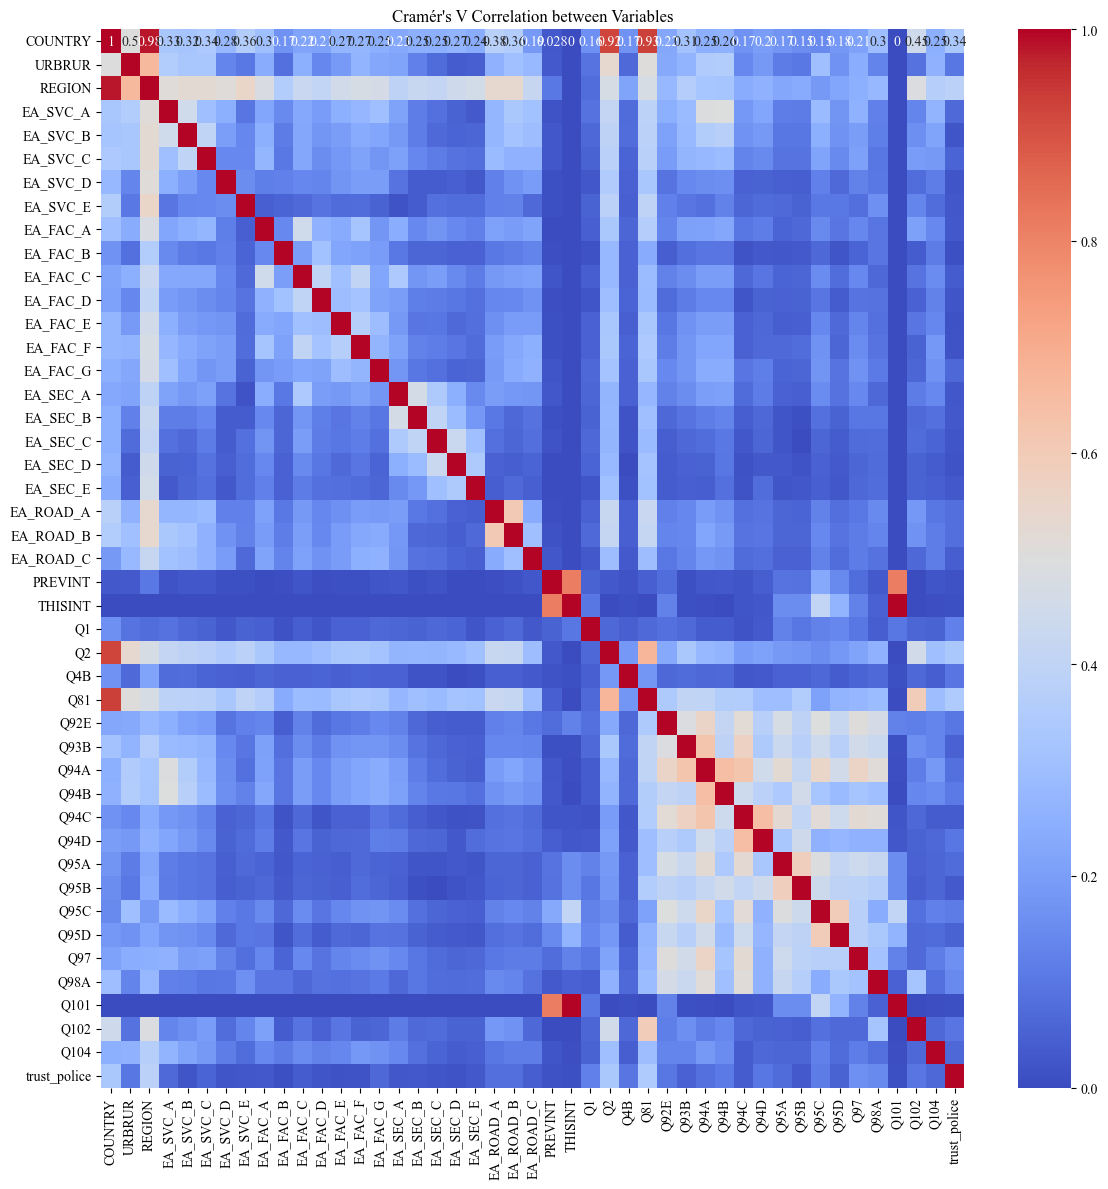

In [135]:
# [Source]: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    return cramers_corrected_stat(confusion_matrix)


# Sample DataFrame
columns = variable_names_subset_1 + ['trust_police']
df = df_as_factors[columns]

# List of column names
cols = df.columns.tolist()
corrM = np.zeros((len(cols), len(cols)))

# Compute Cramér's V for all pairs of variables
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_v(df[col1], df[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

# Set the diagonal to 1
np.fill_diagonal(corrM, 1)

# Create a DataFrame for the correlation matrix
corr = pd.DataFrame(corrM, index=cols, columns=cols)

# Visualize the results using a heatmap
fig, ax = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Cramér's V Correlation between Variables")
plt.tight_layout()
plt.show()

# country with region, Q2 (language) and A81 (ethnic community/tribe) highly correlated
# Q101 and thisint; and prevint also but less


In [136]:
# Cramers V of variables country and region
cramers_v(df_as_factors['COUNTRY'], df_as_factors['REGION'])

0.9805343435212469

In [192]:
# Remove feature 'THISINT' 
variable_names_subset_1.remove('THISINT')

# Remove 'Gender This Interview' to variable labels list
variable_labels_subset_1.remove("Gender This Interview")

# Add 'THISINT' from exclude varliables list
exclude_variables = variable_names_subset_1 + ['trust_police', 'Q41G', 'COUNTRY.old.spelling', 'COUNTRY_R7List', 'COUNTRY_R6List', 'COUNTRY_R5List', 'THISINT' ]

#### Select feature subsets and perform one-hot encoding

In [138]:
# Select two feature subsets and apply one-hot encoding

# factor_encoded_df = df_as_factors.astype(str)
# select the two feature subsets
feature_subset_1 = df_as_factors[variable_names_subset_1]
feature_subset_2 = df_as_factors.drop(columns=exclude_variables)

# print the shape
print(feature_subset_1.shape) # 44 columns included

# apply one-hot encoding
feature_subset_1_onehot = pd.get_dummies(feature_subset_1)
feature_subset_2_onehot = pd.get_dummies(feature_subset_2)


# check the shape of the encoded feature subsets
print("encoded_feature_subset_1 shape:", feature_subset_1_onehot.shape) 
print("encoded_feature_subset_2 shape:", feature_subset_2_onehot.shape)

print(feature_subset_1_onehot)

(47306, 43)
encoded_feature_subset_1 shape: (47306, 1804)
encoded_feature_subset_2 shape: (47306, 3693)
       COUNTRY_Angola  COUNTRY_Benin  COUNTRY_Botswana  COUNTRY_Burkina Faso  \
0                True          False             False                 False   
1                True          False             False                 False   
2                True          False             False                 False   
3                True          False             False                 False   
4                True          False             False                 False   
...               ...            ...               ...                   ...   
47301           False          False             False                 False   
47302           False          False             False                 False   
47303           False          False             False                 False   
47304           False          False             False                 False   
47305           

#### Split the one-hot encoded dataset in training and test sets

In [195]:
# Split the data into training and test sets 

# define X and y for LR, SVM, and MLP models
X_subset1_onehot = feature_subset_1_onehot
X_subset2_onehot = feature_subset_2_onehot

y = df_as_factors['trust_police']

# first feature subset model                                                
X_train_subset1_onehot, X_test_subset1_onehot, y_train, y_test = train_test_split(X_subset1_onehot, y,
                                                test_size=0.2, stratify=y, # 20% to test set
                                                shuffle=True, random_state=42) # shuffle data before splitting

# second feature subset model
X_train_subset2_onehot, X_test_subset2_onehot, y_train, y_test = train_test_split(X_subset2_onehot, y, 
                                                test_size=0.2, stratify=y, 
                                                shuffle=True, random_state=42)


# print the shapes of the resulting sets (just to check)
print("X_train_subset1_onehot shape:", X_train_subset1_onehot.shape)
print("X_test_subset1_onehot shape:", X_test_subset1_onehot.shape, "\n")
print("X_train_subset2_onehot shape:", X_train_subset2_onehot.shape)
print("X_test_subset2_onehot shape:", X_test_subset2_onehot.shape, "\n")
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_subset1_onehot shape: (37844, 1804)
X_test_subset1_onehot shape: (9462, 1804) 

X_train_subset2_onehot shape: (37844, 3693)
X_test_subset2_onehot shape: (9462, 3693) 

y_train shape: (37844,)
y_test shape: (9462,)


### Dataframe 2: Categorical Label Encoded

- For Random Forest and XGBoost Models

#### Load dataset

In [140]:
# Load categorical label encoded dataset

# file path to dataset from current directory 
## for local computer:
csv_file_path_label_encoded = "./afrobaro_dataset/afrobarometer_all_countries_v5.csv"
## for uni gpu shell:
#csv_file_path_label_encoded = "./afrobaro_as_labels.csv"

# read the CSV file into a DataFrame
df_label_encoded = pd.read_csv(csv_file_path_label_encoded)

# see df
print(df_label_encoded.head())


   COUNTRY  COUNTRY.old.spelling  COUNTRY_R7List  COUNTRY_R6List  \
0        2                     2              36              38   
1        2                     2              36              38   
2        2                     2              36              38   
3        2                     2              36              38   
4        2                     2              36              38   

   COUNTRY_R5List  URBRUR  URBRUR_COND  REGION  EA_SVC_A  EA_SVC_B  ...  \
0              39       1            1    1790         1         1  ...   
1              39       1            1    1790         1         0  ...   
2              39       1            1    1790         1         0  ...   
3              39       1            1    1790         1         0  ...   
4              39       1            1    1790         1         0  ...   

   R8part  AGE_v1  AGE_v1.1  AGE_v2_UN  AGE_v2.1_UN  AGE_v3_AU  AGE_v4  \
0       1       2         2          2            2          1    

#### Select feature subsets

In [141]:

# select two feature subsets
feature_subset_1_label_encoded = df_label_encoded[variable_names_subset_1]
feature_subset_2_label_encoded = df_label_encoded.drop(columns=exclude_variables)

# print their shape
print(feature_subset_1_label_encoded.shape)
print(feature_subset_2_label_encoded.shape)


(47306, 43)
(47306, 314)


#### Split the categorical dataset in training and test sets

In [142]:
# Split the data into training and test sets 

# define X and y
X_subset1_label_encoded = feature_subset_1_label_encoded
X_subset2_label_encoded = feature_subset_2_label_encoded

y = df_label_encoded['trust_police']

# first feature subset model 
X_train_subset1_label_encoded, X_test_subset1_label_encoded, y_train, y_test = train_test_split(X_subset1_label_encoded, y,
                                                test_size=0.2, stratify=y, # 20% to test set
                                                shuffle=True, random_state=42) # shuffle data before splitting

# second feature subset model
X_train_subset2_label_encoded, X_test_subset2_label_encoded, y_train, y_test = train_test_split(X_subset2_label_encoded, y, 
                                                test_size=0.2, stratify=y, 
                                                shuffle=True, random_state=42)


# print the shapes of the resulting sets (just to check)
print("X_train_subset1_label_encoded shape:", X_train_subset1_label_encoded.shape)
print("X_test_subset1_label_encoded shape:", X_test_subset1_label_encoded.shape, "\n")
print("X_train_subset2_label_encoded shape:", X_train_subset2_label_encoded.shape)
print("X_test_subset2_label_encoded shape:", X_test_subset2_label_encoded.shape, "\n")
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_subset1_label_encoded shape: (37844, 43)
X_test_subset1_label_encoded shape: (9462, 43) 

X_train_subset2_label_encoded shape: (37844, 314)
X_test_subset2_label_encoded shape: (9462, 314) 

y_train shape: (37844,)
y_test shape: (9462,)


### Check if samples use the same rows

In [13]:
# Check indices of the different training and test sets (should be the same)

# check if X_train uses the same sample of rows in all four subsets
print("X_train four samples:")
print(all(X_train_subset1_label_encoded.index == X_train_subset2_label_encoded.index))
print(all(X_train_subset1_onehot.index == X_train_subset2_onehot.index))
print(all(X_train_subset1_onehot.index == X_train_subset1_label_encoded.index))

# check if X_train is then also equal to y_train in row indexes 
print("\nX_train and y_train:")
print(all(X_train_subset1_label_encoded.index == y_train.index))

# check if test uses the same sample of rows
print("\nX_test four samples:")
print(all(X_test_subset1_label_encoded.index == X_test_subset1_label_encoded.index))
print(all(X_test_subset1_onehot.index == X_test_subset1_onehot.index))
print(all(X_test_subset1_onehot.index == X_test_subset1_label_encoded.index))

# 
print("\nX_test and y_test:")
print(all(X_test_subset1_label_encoded.index == y_test.index))


# just to check if these are the same;
print("\n\n(Target label encoded and target categorical:)")
print(all(df_label_encoded['trust_police'] == df_as_factors['trust_police']))


X_train four samples:
True
True
True

X_train and y_train:
True

X_test four samples:
True
True
True

X_test and y_test:
True


(Target label encoded and target categorical:)
True


# Modelling

## Baseline Model 

In [162]:
# Baseline Model Feature Subset 1
dummy = DummyClassifier(strategy="uniform").fit(X_train_subset1_label_encoded, y_train)
y_pred = dummy.predict(X_test_subset1_label_encoded)
dummy_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50      4767
           1       0.49      0.50      0.50      4695

    accuracy                           0.50      9462
   macro avg       0.50      0.50      0.50      9462
weighted avg       0.50      0.50      0.50      9462



In [163]:
# Baseline Model Feature Subset 2
dummy = DummyClassifier(strategy="uniform").fit(X_train_subset2_label_encoded, y_train)
y_pred = dummy.predict(X_test_subset1_label_encoded)
dummy_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      4767
           1       0.50      0.51      0.51      4695

    accuracy                           0.51      9462
   macro avg       0.51      0.51      0.51      9462
weighted avg       0.51      0.51      0.51      9462



## Logistic Regression Model (LR)

In [17]:
# LR Model Feature Subset 1 with Grid Search

# Link source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty term
    # 'solver': ['liblinear', 'saga']  # Option: Solver for optimization 
}
    ## elasticnet not included yet but you could 

# Initialize the logistic regression model
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)

# Perform grid search with cross-validation
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy') # use f1 as scoring
                                                                # 'f1_weighted'
                                                                # 'accuracy'
                                                                # 'f1' -> 'for binary targets'
grid_search.fit(X_train_subset1_onehot, y_train)

# Retrieve the best combination of hyperparameters
lr1_best_params = grid_search.best_params_
print("Best Hyperparameters LR1:", lr1_best_params)

# Evaluate the model with the best hyperparameters
lr_model_1 = grid_search.best_estimator_ # refitted estimator (model) is available at best_estimator_
lr1_acc = round(grid_search.best_score_, 2)
print("Best score (accuracy) LR1:", lr1_acc)   # f1_macro: 0.67,  accuracy: 0.65, f1: 0.65

# Runtime: 3m

# Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}


Best Hyperparameters LR1: {'C': 0.1, 'penalty': 'l2'}
Best score (accuracy) LR1: 0.67


In [18]:
# LR Model Feature Subset 2 with Grid Search

# Perform grid search with cross-validation
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_subset2_onehot, y_train)

# Get the best hyperparameters
lr2_best_params = grid_search.best_params_
print("Best Hyperparameters LR2:", lr2_best_params)

# Evaluate the model with the best hyperparameters
lr_model_2 = grid_search.best_estimator_ # refitted estimator (model) is available at best_estimator_
lr2_acc = round(grid_search.best_score_, 2)
print("Best score (accuracy) LR2:", lr2_acc)

# Runtime: 13m

Best Hyperparameters LR2: {'C': 0.1, 'penalty': 'l1'}
Best score (accuracy) LR2: 0.81


## Random Forest Model (RF)

In [19]:
# RF Model Feature Subset 1 with Grid Search

# ------------------------------------------------------------------------------
# Common rf classifier and parameter grid

# Initialize the model
rf_classifier = RandomForestClassifier()

# Define search space
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# ------------------------------------------------------------------------------

# Perform grid search
rf_grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, 
                              scoring='accuracy', n_jobs=-1)


rf_grid_search.fit(X_train_subset1_label_encoded, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters (RF1): ", rf_grid_search.best_params_)

# Assign the best estimator found by grid search to rf model 1
rf_model_1 = rf_grid_search.best_estimator_  # rf_model_1 is best rf model 
# Evaluate the model with the best hyperparameters
rf1_acc = round(rf_grid_search.best_score_, 2)
print("Best score (accuracy) RF1: ", rf1_acc)

# none, min samples leaf 1, min samples split 10, n estimators 200 --> 0.67

# Runtime: 7m

Best set of hyperparameters (RF1):  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best score (accuracy) RF1:  0.67


In [20]:
# RF Model Feature Subset 2 with Grid Search

# Perform grid search 
rf_grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, 
                              scoring='accuracy', n_jobs=-1)

rf_grid_search.fit(X_train_subset2_label_encoded, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters (RF2): ", rf_grid_search.best_params_)

# Assign the best estimator found by grid search to rf model 1
rf_model_2 = rf_grid_search.best_estimator_  # rf_model_1 is best rf model 

# Evaluate the model with the best hyperparameters
rf2_acc = round(rf_grid_search.best_score_, 2)
print("Best score (accuracy) RF2: ", rf2_acc)

# 20m runtime

Best set of hyperparameters (RF2):  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best score (accuracy) RF2:  0.81


## XGBoost Model (XGB)

In [143]:
# XGBoost Model

# [Source Code]: https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d

# Common part model 1 and 2

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7], # deeper is more complex, but also higher risk of overfitting
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'min_child_weight': [1, 3, 5, 10]
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier(random_state=42)


#  --------------------------------------------------------------------------------------
# XGB Model Feature Subset 1 with Grid Search
import timeit

start = timeit.default_timer()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_subset1_label_encoded, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters XGB1: ", grid_search.best_params_)
print("Best score (accuracy) XGB1: ", round(grid_search.best_score_, 2))

xgb1_acc = round(grid_search.best_score_, 2)

# Assign the model 
xgb_model_1 = grid_search.best_estimator_


stop = timeit.default_timer()
print('Time: ', round((stop - start)/60), 2)  

# learning rate 0.1, max depth 7, subsample 0.7, min child weight 10 -> 0.67

# 3.5/4m runtime cv=10
# 1.5m runtime cv=5

Best set of hyperparameters XGB1:  {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.7}
Best score (accuracy) XGB1:  0.67
Time:  2 2


In [22]:
# Perform cross-validation with the best model
cv_results_best_model = cross_val_score(xgb_model_1, X_train_subset1_label_encoded, y_train, cv=5)

# Print the accuracy for each fold
print("Performance of each fold with the best XGB model for feature subset 1:")
for i, accuracy in enumerate(cv_results_best_model):
    print(f"Fold {i+1}: Accuracy - {round(accuracy, 2)}")

Performance of each fold with the best XGB model for feature subset 1:
Fold 1: Accuracy - 0.67
Fold 2: Accuracy - 0.67
Fold 3: Accuracy - 0.66
Fold 4: Accuracy - 0.67
Fold 5: Accuracy - 0.66


In [23]:
# XGB Model Feature Subset 2 with Grid Search

start = timeit.default_timer()

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7], # deeper is more complex, but also higher risk of overfitting
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'min_child_weight': [1, 3, 5, 10]
}
# Create the XGBoost model object
xgb_model = xgb.XGBClassifier(random_state=42)

# Create the GridSearchCV object
grid_search_2 = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search_2.fit(X_train_subset2_label_encoded, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters XGB2: ", grid_search_2.best_params_)
print("Best score (accuracy) XGB2: ", round(grid_search_2.best_score_, 2))

xgb2_acc = round(grid_search_2.best_score_, 2)

# assign the model
xgb_model_2 = grid_search_2.best_estimator_

stop = timeit.default_timer()
print('Time: ', stop - start)  

# learning rate 0.1, max depth 7, min child weight 3, saubsample 1 --> 0.82
# 17m runtime (with cv=10) 8m with ch=5 (30m)

Best set of hyperparameters XGB2:  {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.7}
Best score (accuracy) XGB2:  0.82
Time:  481.38043241598643


## Multi-Layer Perceptron Model (MLP)

In [160]:
# MLP Model Feature Subset 1

# [Source Code]: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

# Function to create model, required for KerasClassifier
def create_model():
 # create model
 model = Sequential()
 # add input shape layer
 model.add(keras.Input(shape=X_train_subset1_onehot.shape[1:]))
 # add Dense layers
 model.add(Dense(12, activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # 
 return model

# fix random seed for reproducibility
seed = 42
tensorflow.random.set_seed(seed)

# create model
model = KerasClassifier(model=create_model, verbose=0)

param_grid = {
   'batch_size': [10, 20, 40, 60, 80, 100],
   'epochs': [10, 50, 100]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train_subset1_onehot, y_train)

# Summarize results
# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters MLP1: ", grid_result.best_params_)
print("Best score (accuracy) MLP1: ", round(grid_result.best_score_, 2))

## (Print scores of different hyperparameter combinations)
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# 10m run
mlp1_acc = round(grid_result.best_score_, 2)
mlp_model_1 = grid_result.best_estimator_

# Runtime: 20m; 14m

Best set of hyperparameters MLP1:  {'batch_size': 100, 'epochs': 10}
Best score (accuracy) MLP1:  0.66


In [161]:
# MLP Model Feature Subset 1

# [Source Code]: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

# Function to create model, required for KerasClassifier
def create_model():
 # create model
 model = Sequential()
 # add input shape layer
 model.add(keras.Input(X_train_subset2_onehot.shape[1:]))
 # add Dense layers
 model.add(Dense(12, activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # 
 return model

# fix random seed for reproducibility
seed = 42
tensorflow.random.set_seed(seed)

# create model
model = KerasClassifier(model=create_model, verbose=0)

param_grid = {
   'batch_size': [10, 20, 40, 60, 80, 100],
   'epochs': [10, 50, 100]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_subset2_onehot, y_train)

# Summarize results
# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters MLP2: ", grid_result.best_params_)
print("Best score (accuracy) MLP2: ", round(grid_result.best_score_, 2))

## (Print scores of different hyperparameter combinations)
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# 10m run
mlp2_acc = grid_result.best_score_
mlp_model_2 = grid_result.best_estimator_

# 21m

Best set of hyperparameters MLP2:  {'batch_size': 80, 'epochs': 10}
Best score (accuracy) MLP2:  0.81


## Select Best Model 

In [26]:
# Compare model performances

# Create dictionary of model accuracies
data2 = { 'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Multi-Layer Perceptron'],
    'Acc Feature Subset 1': [lr1_acc, rf1_acc, xgb1_acc, mlp1_acc],
    'Acc Feature Subset 2': [lr2_acc, rf2_acc, xgb2_acc, mlp2_acc],
}
# Create a DataFrame from the data
model_comparison_table = pd.DataFrame(data2)

# Print DataFrame without row indices
print("Table Model Comparison:")
print(model_comparison_table.to_string(index=False))


Table Model Comparison:
                 Model  Acc Feature Subset 1  Acc Feature Subset 2
   Logistic Regression                  0.67              0.810000
         Random Forest                  0.67              0.810000
               XGBoost                  0.67              0.820000
Multi-Layer Perceptron                  0.66              0.808028


# Out-of-Sample Evaluation & Error Analysis

## Prediction and Classification Report


In [27]:
# XGBoost Prediction feature subset 1
y_pred_xgb1 = xgb_model_1.predict(X_test_subset1_label_encoded)

# generate a classification report
print("\nClassification Report Test Set (XGB1): \n", classification_report(y_test, y_pred_xgb1))

# lr1_f1score = round(f1_score(y_test, y_pred_lr1))
xgb1_test_acc = round(accuracy_score(y_test, y_pred_xgb1), 2)
print("XGBoost Model 1 Accuracy:", xgb1_test_acc)


# -------------------------------------------------------------------------------------
# XGBoost Prediction feature subset 2
y_pred_xgb2 = xgb_model_2.predict(X_test_subset2_label_encoded)

# generate a classification report
print("\n\nClassification Report Test Set (XGB2): \n", classification_report(y_test, y_pred_xgb2))

# lr1_f1score = round(f1_score(y_test, y_pred_lr1))
xgb2_test_acc = round(accuracy_score(y_test, y_pred_xgb2), 2)
print("XGBoost Model 2 Accuracy:", xgb2_test_acc)



Classification Report Test Set (XGB1): 
               precision    recall  f1-score   support

           0       0.66      0.70      0.68      4767
           1       0.68      0.64      0.66      4695

    accuracy                           0.67      9462
   macro avg       0.67      0.67      0.67      9462
weighted avg       0.67      0.67      0.67      9462

XGBoost Model 1 Accuracy: 0.67


Classification Report Test Set (XGB2): 
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      4767
           1       0.81      0.83      0.82      4695

    accuracy                           0.82      9462
   macro avg       0.82      0.82      0.82      9462
weighted avg       0.82      0.82      0.82      9462

XGBoost Model 2 Accuracy: 0.82


## Confusion Matrix

In [28]:
# Confusion matrix feature subset 1
print("Confusion Matrix XGBoost Model 1: \n", confusion_matrix(y_test, y_pred_xgb1))

# Confusion matrix feature subset 2
print("\nConfusion Matrix XGBoost Model 2: \n", confusion_matrix(y_test, y_pred_xgb2))

Confusion Matrix XGBoost Model 1: 
 [[3338 1429]
 [1690 3005]]

Confusion Matrix XGBoost Model 2: 
 [[3861  906]
 [ 805 3890]]


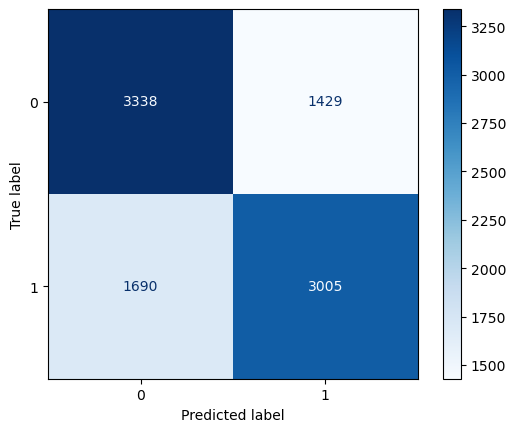

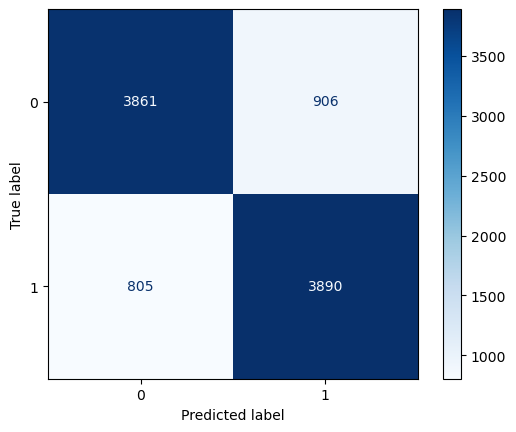

In [32]:
# Plot confusion matrices with heat map

from sklearn.metrics import ConfusionMatrixDisplay

# Heatmap feature subset 1
cm = confusion_matrix(y_test, y_pred_xgb1, labels=xgb_model_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model_1.classes_)
disp.plot(cmap='Blues')
plt.show()

# Heatmap feature subset 2
cm = confusion_matrix(y_test, y_pred_xgb2, labels=xgb_model_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model_2.classes_)
disp.plot(cmap='Blues')
plt.show()

## ROC-AUC Curves


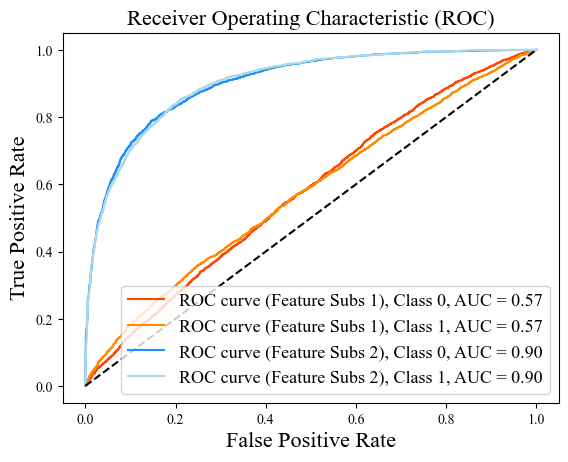

In [76]:
## ROC-AUC Curves

# Set the font family to Times New Roman (for all plots)
rcParams['font.family'] = 'Times New Roman'

# Predict the pribabilities of each class for each row 
predicted_probs_model1 = xgb_model_1.predict_proba(X_test_subset1_label_encoded)
predicted_probs_model2 = xgb_model_2.predict_proba(X_test_subset2_label_encoded)

def plot_roc_curves(predicted_probs_list, y_test, model_names):
    plt.figure()
    colors = [['#FF4500', '#FF8C00'], ['#1E90FF', '#ADD8E6']]  # Define custom colors for each model
                                            # and class; [[two shades of orange], [two shades of blue]]
                                    
    for i, (predicted_probs, model_name) in enumerate(zip(predicted_probs_list, model_names)):
        for j in range(predicted_probs.shape[1]):  # Iterate over classes
            fpr, tpr, _ = roc_curve(y_test, predicted_probs[:, j], pos_label=j)
            roc_auc = auc(fpr, tpr)
            color = colors[i][j]  # Use different shades of the same color for each class
            plt.plot(fpr, tpr, color=color, 
                     label='ROC curve ({}), Class {}, AUC = {:.2f}'.format(model_name, j, roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
    plt.legend(loc="lower right", fontsize=13)
    plt.show()

plot_roc_curves([predicted_probs_model1, predicted_probs_model2], y_test, 
                ["Feature Subs 1", "Feature Subs 2"])


In [ ]:
# Conclusion: The ROC-AUC curves shows no clear problems; both classes follow a similar trend; only that
# this could be improved further (improve performance itself)

## Feature Importances XGBoost Model 1

### Feature Importance with 'Gain'

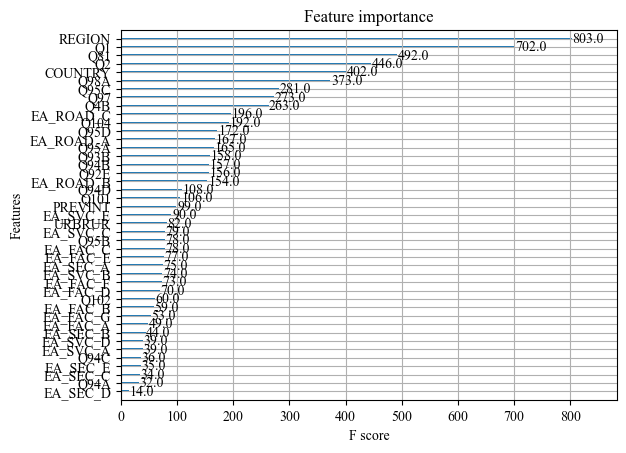

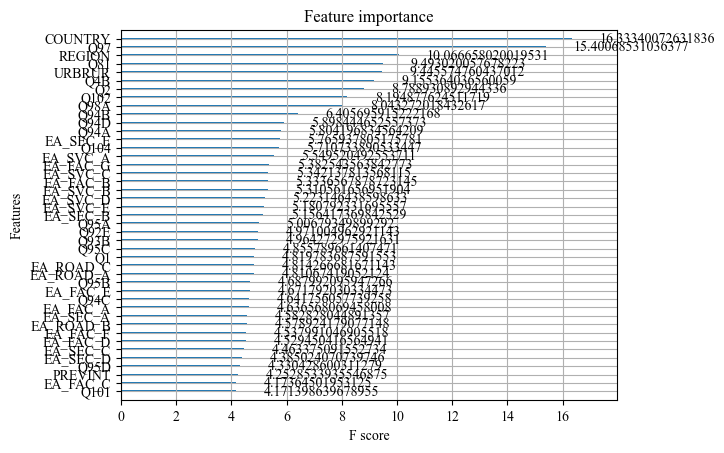

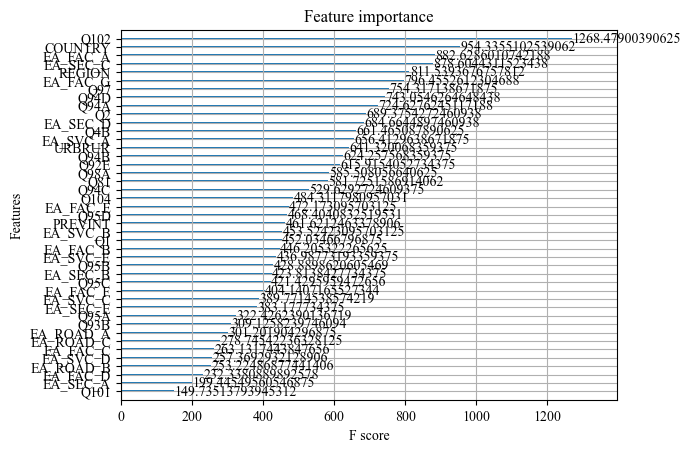

      feature  importance
0     COUNTRY    0.061899
38        Q97    0.058364
2      REGION    0.038150
27        Q81    0.035976
1      URBRUR    0.035796
26        Q4B    0.034696
25         Q2    0.033308
41       Q102    0.031056
39       Q98A    0.030482
31       Q94B    0.024276
33       Q94D    0.022353
30       Q94A    0.021996
19   EA_SEC_E    0.021851
42       Q104    0.021642
3    EA_SVC_A    0.021031
14   EA_FAC_G    0.020398
5    EA_SVC_C    0.020245
9    EA_FAC_B    0.020213
4    EA_SVC_B    0.020126
6    EA_SVC_D    0.019794
7    EA_SVC_E    0.019634
16   EA_SEC_B    0.019541
34       Q95A    0.018974
28       Q92E    0.018839
29       Q93B    0.018813
36       Q95C    0.018402
24         Q1    0.018266
22  EA_ROAD_C    0.018245
20  EA_ROAD_A    0.018231
35       Q95B    0.017766
12   EA_FAC_E    0.017705
32       Q94C    0.017591
8    EA_FAC_A    0.017571
15   EA_SEC_A    0.017368
21  EA_ROAD_B    0.017353
13   EA_FAC_F    0.017198
11   EA_FAC_D    0.017165
17   EA_SEC_

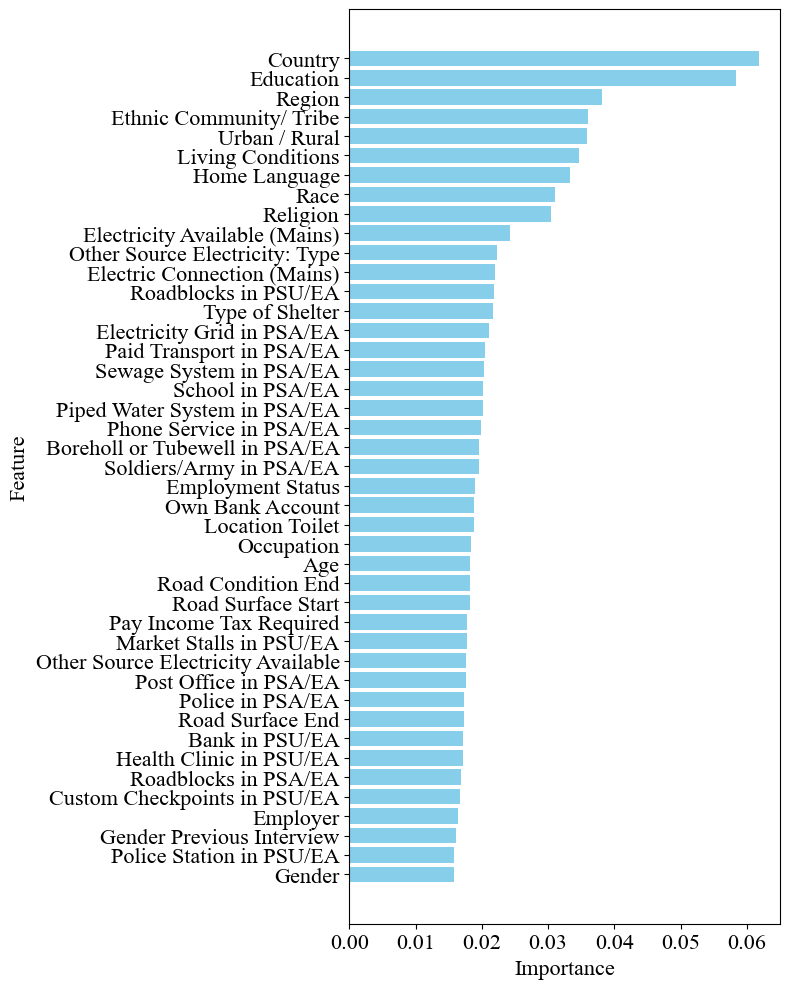

In [193]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# call model
model = xgb_model_1

# Extra: Plot feature importances
plot_importance(model, importance_type='weight')
plt.show()

plot_importance(model, importance_type='gain') # this is the default of .feature_importances_ for XGBoost
plt.show()

plot_importance(model, importance_type='cover')
plt.show()


# Plot feature importances with gain:
def feature_importances():
    # Get feature importances using feature_importances_
    importances = model.feature_importances_ # uses gain: average improvement in loss (with split)
    importance_df = pd.DataFrame({'feature': X_train_subset1_label_encoded.columns, 'importance': importances})
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    print(importance_df)



    # Map feature names to labels
    importance_df['label'] = importance_df['feature'].map(variable_names_dict) 
                                                        # adds column 'label' to 'importance_df' 
                                                        # with the corresponding label of 'feature' from the 
                                                        # 'variable_names_dict' dictionary
    # Plot feature importances with labels
    plt.figure(figsize=(8, 10))
                                        #! use .iloc[:15] to see subset; i.e. 15 most important features
    plt.barh(importance_df['label'], importance_df['importance'], color='skyblue') 
    plt.xlabel('Importance', fontsize='16')
    plt.ylabel('Feature', fontsize='16')
    # plt.title('Feature Importances', fontsize='14') # Not included for use in thesis paper 
    plt.xticks(fontsize=16)  # Adjust font size of the x-axis ticks
    plt.yticks(fontsize=16)  # Adjust font size of the y-axis ticks
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.tight_layout()
    plt.show()
    return

feature_importances()

# If the feature importances plot shows "country" and "education" as the most important features, 
# it suggests that these features are highly influential in determining the model's predictions 
# based on the frequency of their use in decision-making.

### Permutation Feature Importance

In [145]:
# [Source:] https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# [Source:] https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost

from sklearn.inspection import permutation_importance

result = permutation_importance(
    xgb_model_1, X_test_subset1_label_encoded, y_test, n_repeats=10, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, variable_labels_subset_1)


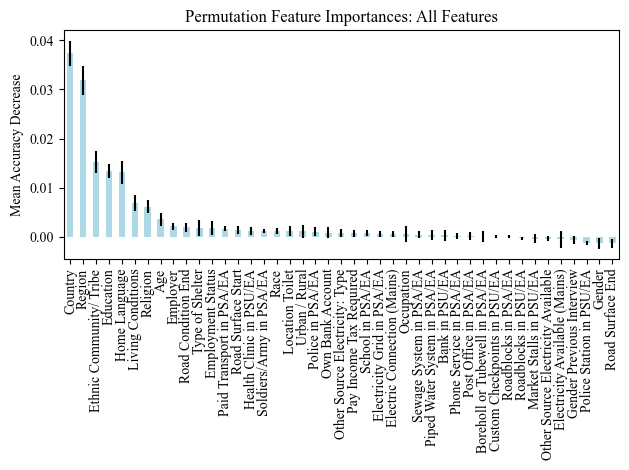

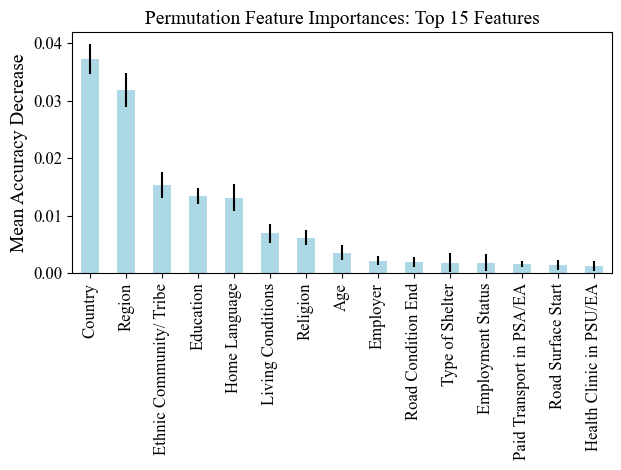

In [153]:
#--- Plot all feature imoprtance, sorted in descending order ---
importances_df = pd.DataFrame({
    'importances_mean': result.importances_mean,
    'importances_std': result.importances_std
}, index=variable_labels_subset_1)

# Sort by mean importance
importances_df = importances_df.sort_values(by='importances_mean', ascending=False)

# Select top 10 features
all_importances = importances_df

# Plot
fig, ax = plt.subplots()
all_importances['importances_mean'].plot.bar(yerr=all_importances['importances_std'], ax=ax, color='lightblue')
ax.set_title("Permutation Feature Importances: All Features")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
# save the plot in higher resolution
plt.savefig('feature_imp_all_pyton_save.png', dpi=1200)
plt.show()


#--- Plot top 10 feature importances ---
# Create a DataFrame for importances
importances_df = pd.DataFrame({
    'importances_mean': result.importances_mean,
    'importances_std': result.importances_std
}, index=variable_labels_subset_1)

# Sort by mean importance
importances_df = importances_df.sort_values(by='importances_mean', ascending=False)

# Select top 10 features
top_15_importances = importances_df.head(15)

# Plot
fig, ax = plt.subplots()
top_15_importances['importances_mean'].plot.bar(yerr=top_15_importances['importances_std'], 
                                                ax=ax, color='lightblue', fontsize=12)

ax.set_title("Permutation Feature Importances: Top 15 Features", fontsize=14)
ax.set_ylabel("Mean Accuracy Decrease", fontsize=14)
fig.tight_layout()
# save the plot in higher resolution
plt.savefig('feature_imp_10_pyton_save.png', dpi=1200)
plt.show()



### SHAP Feature Importance

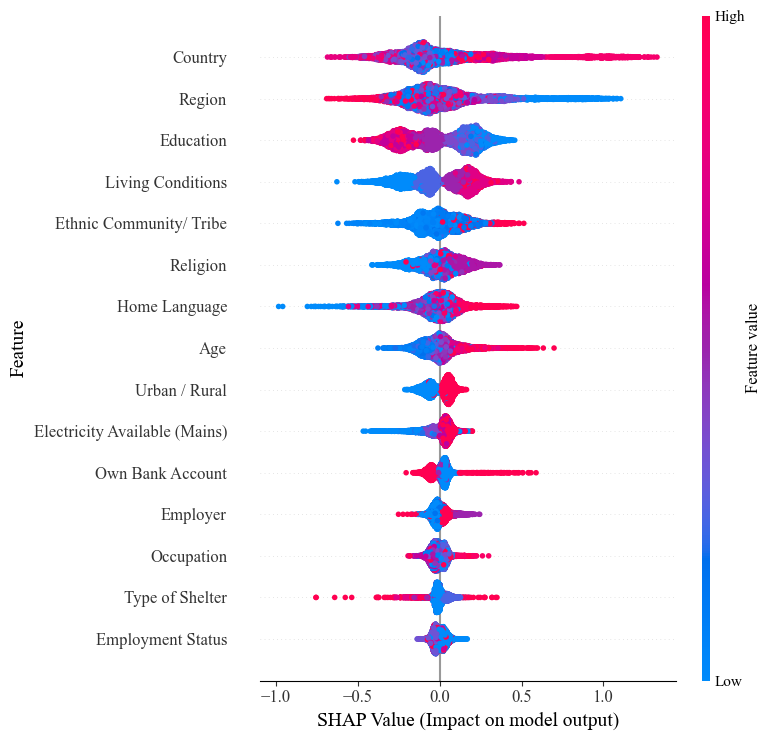

In [60]:
# [Source:] # https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

# Train your model (replace model with your trained model)

# Create an explainer object of your best model
explainer = shap.TreeExplainer(xgb_model_1)

# Compute SHAP values for your dataset (X)
shap_values = explainer.shap_values(X_test_subset1_label_encoded)

# Create a list of labels for each feature based on the variable_names_dict
feature_names_list = [variable_names_dict.get(feature, feature) for feature in X_test_subset1_label_encoded.columns]

# Summary plot with customized feature names
shap.summary_plot(shap_values, X_test_subset1_label_encoded, feature_names=feature_names_list, max_display=15, show=False) 
                                                                        # show=False to be able to customise plot aesthetic

# # Change aesthetic of the plot
# # Set the font family to Times New Roman
# rcParams['font.family'] = 'Times New Roman'

# Get the current figure and axis objects
fig, ax = plt.gcf(), plt.gca()

# Customize plot aesthetics
ax.set_xlabel("SHAP Value (Impact on model output)", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()  # Adjust layout to prevent overlapping elements

# Save or display the plot
plt.show()

## Country Groups Analysis

### (Get Plot Colors)

(0.8978854286812764, 0.939038831218762, 0.977362552864283)
(0.828881199538639, 0.8937639369473279, 0.954725105728566)
(0.7506343713956171, 0.8478431372549019, 0.9282122260668974)
(0.6325259515570935, 0.7976470588235294, 0.8868742791234141)
(0.491764705882353, 0.7219684736639754, 0.8547789311803152)
(0.36159938485198, 0.6427374086889658, 0.8165782391387928)
(0.24816608996539793, 0.5618915801614763, 0.7709803921568628)
(0.15072664359861593, 0.4644521337946943, 0.7207843137254902)
(0.07481737793156479, 0.3732564398308343, 0.6552095347943099)
(0.03137254901960784, 0.28161476355247983, 0.5582622068435218)


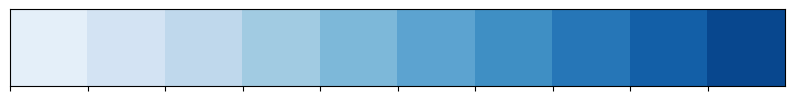

In [210]:
# Get the 'blues' color palette
blues_palette = sns.color_palette("Blues", 10, as_cmap=False)

# Print the RGB color codes
for color in blues_palette:
    print(color)

# Optionally, visualize the palette
sns.palplot(blues_palette)
plt.show()

### Performance per Country

Performance Metrics for Different Groups within Feature 'COUNTRY':
Country: Angola
Accuracy: 0.66
Precision: 0.62
Recall: 0.51
F1 Score: 0.56

Country: Benin
Accuracy: 0.63
Precision: 0.7
Recall: 0.78
F1 Score: 0.74

Country: Botswana
Accuracy: 0.59
Precision: 0.66
Recall: 0.78
F1 Score: 0.72

Country: Burkina Faso
Accuracy: 0.78
Precision: 0.8
Recall: 0.95
F1 Score: 0.87

Country: Cabo Verde
Accuracy: 0.56
Precision: 0.56
Recall: 0.5
F1 Score: 0.53

Country: Cameroon
Accuracy: 0.64
Precision: 0.66
Recall: 0.54
F1 Score: 0.59

Country: Côte d'Ivoire
Accuracy: 0.5
Precision: 0.46
Recall: 0.49
F1 Score: 0.47

Country: Eswatini
Accuracy: 0.61
Precision: 0.6
Recall: 0.39
F1 Score: 0.47

Country: Ethiopia
Accuracy: 0.64
Precision: 0.64
Recall: 0.65
F1 Score: 0.64

Country: Gabon
Accuracy: 0.73
Precision: 0.33
Recall: 0.03
F1 Score: 0.06

Country: Gambia
Accuracy: 0.57
Precision: 0.63
Recall: 0.71
F1 Score: 0.67

Country: Ghana
Accuracy: 0.6
Precision: 0.5
Recall: 0.35
F1 Score: 0.41

Countr

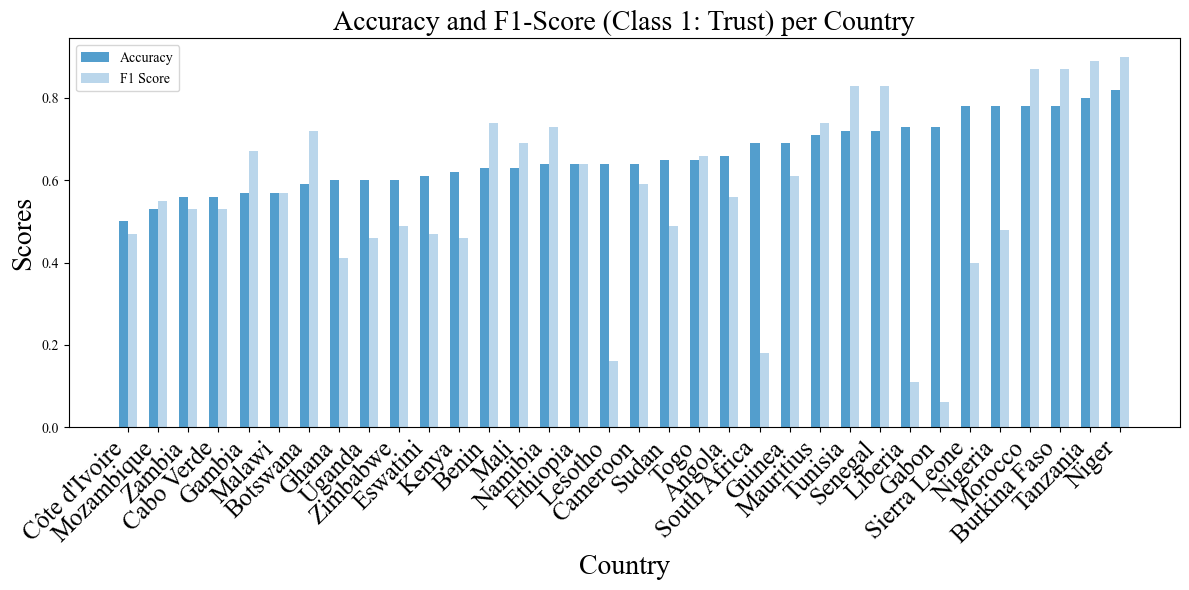

Performance Metrics for Different Groups within Feature 'COUNTRY':
Country: Angola
Accuracy: 0.66
Precision: 0.68
Recall: 0.77
F1 Score: 0.72

Country: Benin
Accuracy: 0.63
Precision: 0.44
Recall: 0.35
F1 Score: 0.39

Country: Botswana
Accuracy: 0.59
Precision: 0.36
Recall: 0.23
F1 Score: 0.28

Country: Burkina Faso
Accuracy: 0.78
Precision: 0.4
Recall: 0.12
F1 Score: 0.18

Country: Cabo Verde
Accuracy: 0.56
Precision: 0.56
Recall: 0.62
F1 Score: 0.59

Country: Cameroon
Accuracy: 0.64
Precision: 0.63
Recall: 0.73
F1 Score: 0.68

Country: Côte d'Ivoire
Accuracy: 0.5
Precision: 0.54
Recall: 0.51
F1 Score: 0.52

Country: Eswatini
Accuracy: 0.61
Precision: 0.61
Recall: 0.78
F1 Score: 0.68

Country: Ethiopia
Accuracy: 0.64
Precision: 0.64
Recall: 0.63
F1 Score: 0.64

Country: Gabon
Accuracy: 0.73
Precision: 0.74
Recall: 0.98
F1 Score: 0.84

Country: Gambia
Accuracy: 0.57
Precision: 0.44
Recall: 0.36
F1 Score: 0.4

Country: Ghana
Accuracy: 0.6
Precision: 0.64
Recall: 0.77
F1 Score: 0.7

Coun

<Figure size 640x480 with 0 Axes>

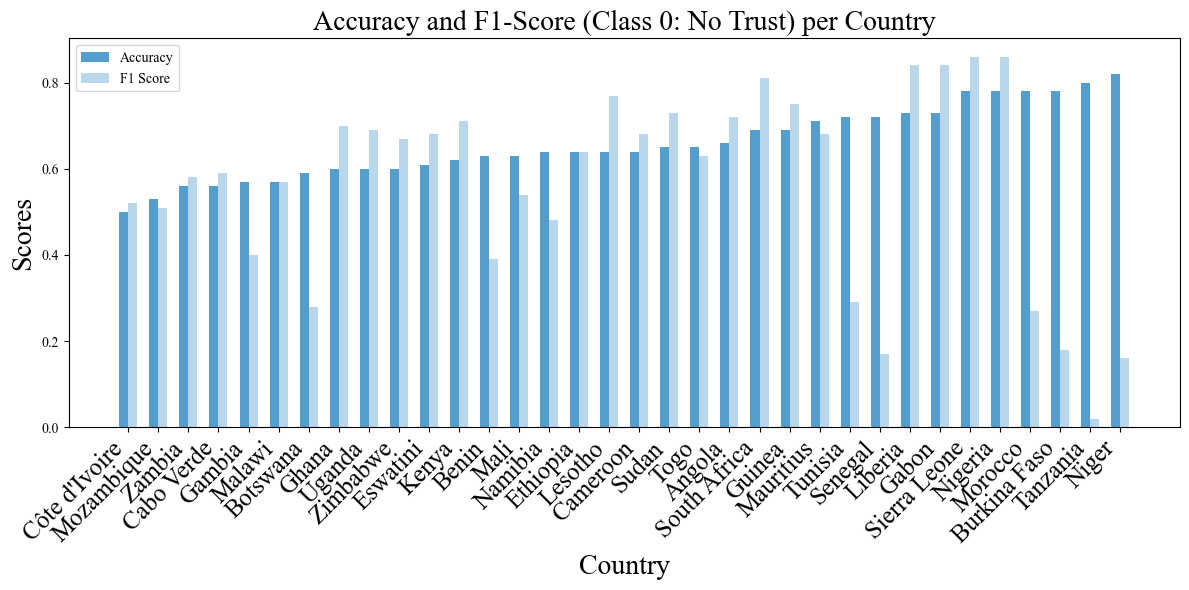

<Figure size 640x480 with 0 Axes>

In [209]:
# Performance of XGBoost Model 1 Per Country Subgroup

def feature_groups_performance(feature, pos_label=1, title_class='(Class 1: Trust)'): 
    # Split the dataset into groups based on the values of 'COUNTRY'
    groups = df_label_encoded.groupby(feature)

    # Get the unique values of 'COUNTRY' to use as labels
    unique_countries = df_as_factors['COUNTRY'].unique()

    # Initialize empty dictionaries to store performance metrics for each group
    accuracy_scores = {}
    precision_scores = {}
    recall_scores = {}
    f1_scores = {}

    # Iterate over each group
    for idx, (group_value, group_data) in enumerate(groups):
        # Prepare data for modeling
        X = group_data[variable_names_subset_1]  # Features
        y = group_data['trust_police']  # Target variable

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Use the trained XGBoost model
        xgb_model_1.fit(X_train, y_train)

        # Predict on the test set
        y_pred = xgb_model_1.predict(X_test)

        # Calculate performance metrics
        accuracy_scores[unique_countries[idx]] = round(accuracy_score(y_test, y_pred), 2)
        precision_scores[unique_countries[idx]] = round(precision_score(y_test, y_pred, pos_label=pos_label), 2)
        recall_scores[unique_countries[idx]] = round(recall_score(y_test, y_pred, pos_label=pos_label), 2)
        f1_scores[unique_countries[idx]] = round(f1_score(y_test, y_pred, pos_label=pos_label), 2) # pos_label=1 default; so here yes trust

    # Print performance metrics for each group
    print("Performance Metrics for Different Groups within Feature 'COUNTRY':")
    for country in unique_countries:
        print(f"Country: {country}")
        print(f"Accuracy: {accuracy_scores.get(country, 'N/A')}")
        print(f"Precision: {precision_scores.get(country, 'N/A')}")
        print(f"Recall: {recall_scores.get(country, 'N/A')}")
        print(f"F1 Score: {f1_scores.get(country, 'N/A')}")
        print()

    # Sort accuracy scores based on values
    sorted_accuracy_scores = {k: v for k, v in sorted(accuracy_scores.items(), key=lambda item: item[1]) if v != 'N/A'}

    # Make sure the keys (countries) are aligned between accuracy and F1 score dictionaries
    common_countries = set(sorted_accuracy_scores.keys()).intersection(f1_scores.keys())

    # Sort common countries based on accuracy scores
    common_countries_sorted = sorted(common_countries, key=lambda country: accuracy_scores[country])

    # Define colors for bars
    color_accuracy = (0.32628988850442137, 0.6186236063052672, 0.802798923490965) #'#1E90FF'    #'lightgreen'  #1E90FF', '#ADD8E6
    color_f1 =  (0.7309496347558632, 0.8394771241830065, 0.9213225682429834) #'skyblue' #'lightsalmon'   # '#FF4500', '#FF8C00'


    # Plot accuracy and F1 score per country
    plt.figure(figsize=(12, 6))
    bar_width = 0.3
    index = np.arange(len(common_countries_sorted))

    plt.bar(index, [accuracy_scores[country] for country in common_countries_sorted], bar_width, label='Accuracy', color=color_accuracy)
    plt.bar(index + bar_width, [f1_scores[country] for country in common_countries_sorted], bar_width, label='F1 Score', color=color_f1)

    plt.xlabel('Country', fontsize=20)
    plt.ylabel('Scores', fontsize=20)
    plt.title(f'Accuracy and F1-Score {(title_class)} per Country', fontsize=20) 
    plt.xticks(index + bar_width / 2, common_countries_sorted, rotation=45, ha='right', fontsize='18')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Save the plot
    plt.savefig('performances_countries_class0.png', dpi=1200)
    return

# ability to detect the class trust in police (positive label =1)
feature_groups_performance('COUNTRY') # South Africa, Lesotho, Liberia, and Gabon

# ability to detect NO trust in police
feature_groups_performance('COUNTRY', pos_label=0, title_class='(Class 0: No Trust)') # Senegal, Burkina Faso, Tanzania, Niger


### Frequency of Each Country in the Sample

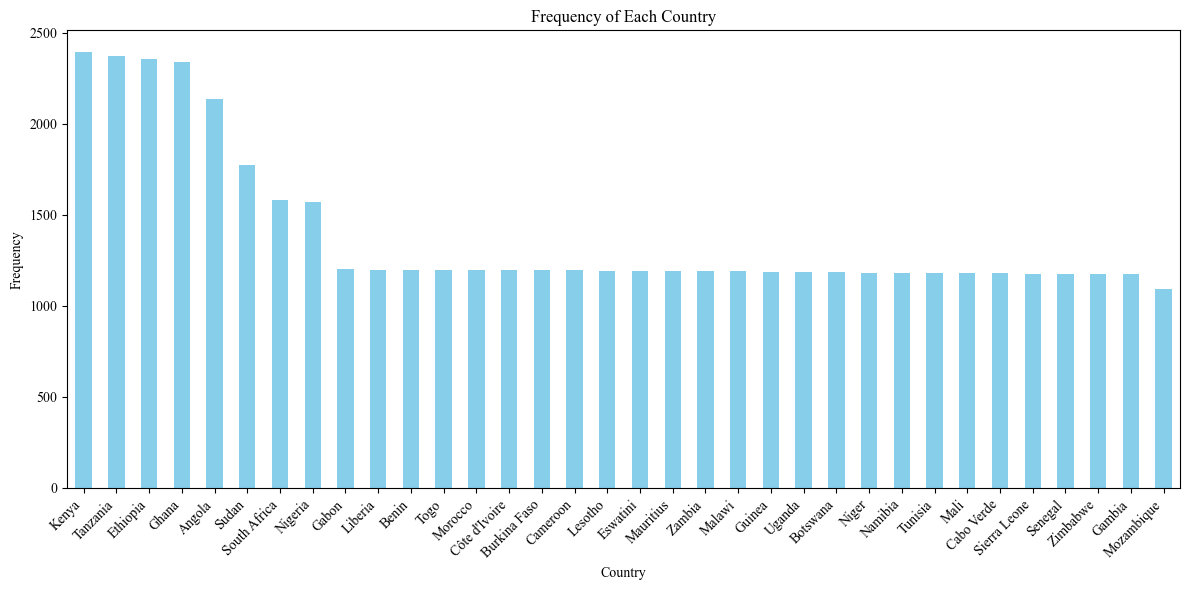

In [99]:
# Frequency of Each Country in the Sample

# Compute the frequency of each category
country_counts = df_as_factors['COUNTRY'].value_counts()

# Set the font family to Times New Roman
rcParams['font.family'] = 'Times New Roman'

# Plot the frequencies with a specific color
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar', color='skyblue')  # Specify the color here
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.title('Frequency of Each Country')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### Target Class Distributions Per Country Plot 1

    COUNTRY  trust_police  counts
0         2             0    1275
1         2             1     858
2         3             0     456
3         3             1     743
4         4             0     405
..      ...           ...     ...
63       35             1     470
64       36             0     606
65       36             1     583
66       37             0     654
67       37             1     521

[68 rows x 3 columns]


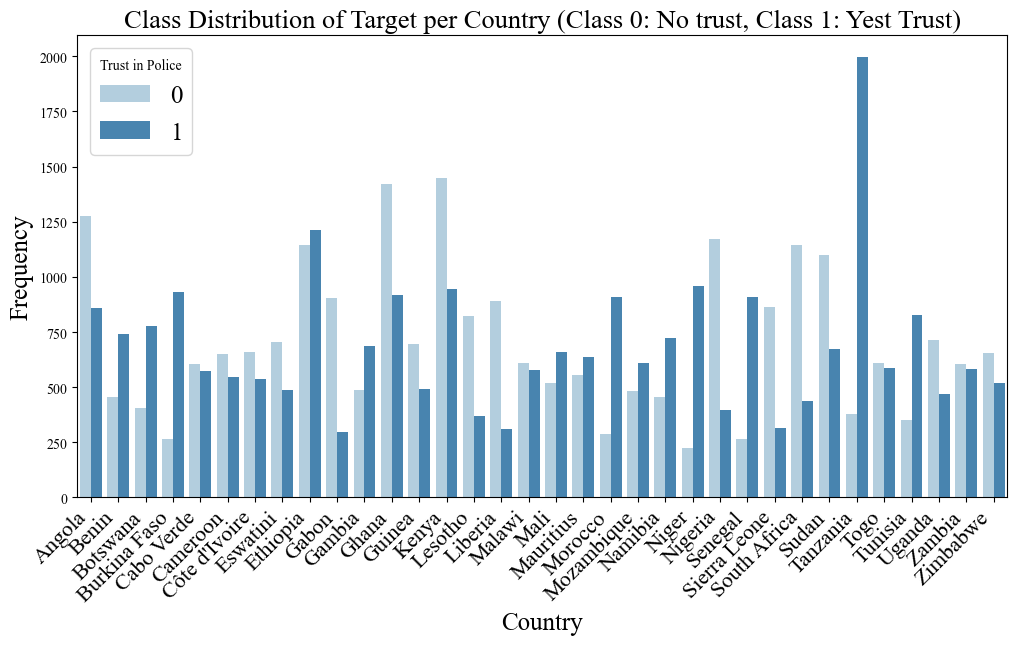

    COUNTRY  trust_police  counts
0         2             0    1275
1         2             1     858
2         3             0     456
3         3             1     743
4         4             0     405
..      ...           ...     ...
63       35             1     470
64       36             0     606
65       36             1     583
66       37             0     654
67       37             1     521

[68 rows x 3 columns]
    COUNTRY  trust_police  counts
6         5             0     267
7         5             1     930
18       11             0     902
19       11             1     298
24       14             0     697
25       14             1     490
30       17             0     889
31       17             1     310
36       21             0     554
37       21             1     635
38       22             0     289
39       22             1     909
44       25             0     224
45       25             1     958
46       26             0    1174
47       26             1

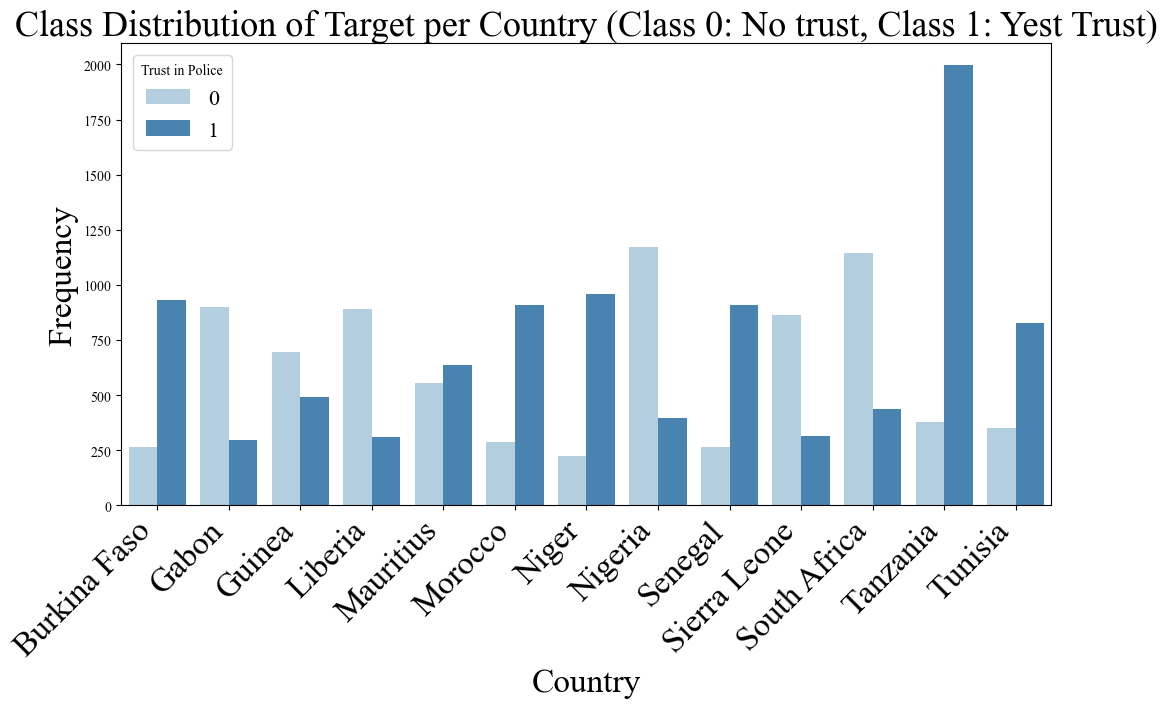

In [170]:
# Plot Target Class Distributions Per Country

color_accuracy = '#1E90FF' #'lightgreen'  #1E90FF', '#ADD8E6
color_f1 =  'skyblue' 

# create dict mappiny numerical label: country name
country_mapping = dict(zip(df_label_encoded['COUNTRY'].unique(), df_as_factors['COUNTRY'].unique()))

# Count the frequencies of each class of 'trust_police' for each 'COUNTRY'
count_data = df_label_encoded.groupby(['COUNTRY', 'trust_police']).size().reset_index(name='counts')
print(count_data)

# select a few countreies
# Filter the DataFrame
# countries_highest_acc = count_data[count_data['COUNTRY'].isin([14, 30, 21, 28, 34, 11, 17, 22, 26, 29, 5, 32, 25])]
# print(countries_highest_acc)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='COUNTRY', y='counts', data=count_data, hue='trust_police', palette='Blues')

# Add title and labels
plt.title('Class Distribution of Target per Country (Class 0: No trust, Class 1: Yest Trust)', fontsize=19)
plt.xlabel('Country', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.legend(title='Trust in Police', loc='upper left', fontsize=18) # labels=['No Trust', 'Yes Trust'], 

# Replace the ticks with country names from the dictionary
current_labels = plt.gca().get_xticklabels()
new_labels = [country_mapping[int(label.get_text())] if int(label.get_text()) in country_mapping else label.get_text() for label in current_labels]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=45, ha='right', fontsize=16)

# Save the plot
plt.savefig('class_dist_all_python_save.png', dpi=1300)
# Show the plot
plt.show()


# create dict mappiny numerical label: country name
country_mapping = dict(zip(df_label_encoded['COUNTRY'].unique(), df_as_factors['COUNTRY'].unique()))

# Count the frequencies of each class of 'trust_police' for each 'COUNTRY'
count_data = df_label_encoded.groupby(['COUNTRY', 'trust_police']).size().reset_index(name='counts')
print(count_data)

# select a few countreies
# Filter the DataFrame
countries_highest_acc = count_data[count_data['COUNTRY'].isin([14, 30, 21, 28, 34, 11, 17, 22, 26, 29, 5, 32, 25])]
print(countries_highest_acc)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=countries_highest_acc, x='COUNTRY', y='counts', hue='trust_police', palette='Blues') #viridis

# Add title and labels
plt.title('Class Distribution of Target per Country (Class 0: No trust, Class 1: Yest Trust)', fontsize=26)
plt.xlabel('Country', fontsize=24)
plt.ylabel('Frequency', fontsize=24)

# set color
plt.legend(title='Trust in Police', loc='upper left',  fontsize=16) #labels=['No Trust', 'Yes Trust'],

# Replace the ticks with country names from the dictionary
current_labels = plt.gca().get_xticklabels()
new_labels = [country_mapping[int(label.get_text())] if int(label.get_text()) in country_mapping else label.get_text() for label in current_labels]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=45, ha='right', fontsize=24)

# Save the plot
plt.savefig('class_dist_13_python_save.png', dpi=1200)
# Show the plot
plt.show()

### Target Class Distribution per Country Plot 2

{'Angola': 2, 'Benin': 3, 'Botswana': 4, 'Burkina Faso': 5, 'Cabo Verde': 6, 'Cameroon': 7, "Côte d'Ivoire": 8, 'Eswatini': 9, 'Ethiopia': 10, 'Gabon': 11, 'Gambia': 12, 'Ghana': 13, 'Guinea': 14, 'Kenya': 15, 'Lesotho': 16, 'Liberia': 17, 'Malawi': 19, 'Mali': 20, 'Mauritius': 21, 'Morocco': 22, 'Mozambique': 23, 'Namibia': 24, 'Niger': 25, 'Nigeria': 26, 'Senegal': 28, 'Sierra Leone': 29, 'South Africa': 30, 'Sudan': 31, 'Tanzania': 32, 'Togo': 33, 'Tunisia': 34, 'Uganda': 35, 'Zambia': 36, 'Zimbabwe': 37}


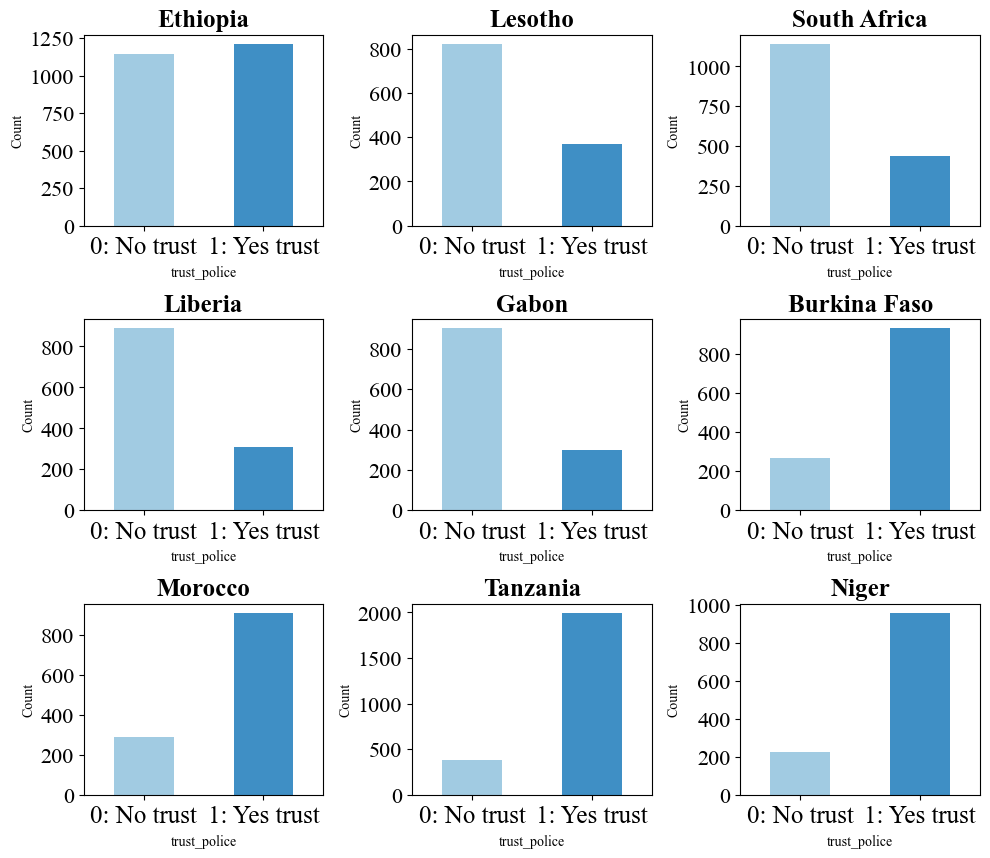

In [211]:
# Plot target class distribution for specified countries

# check unique values
df_label_encoded['COUNTRY'].unique()
df_as_factors['COUNTRY'].unique()

# create dictionary mapping country name (key) to country label (value)
country_mapping = dict(zip(df_as_factors['COUNTRY'].unique(), df_label_encoded['COUNTRY'].unique()))
print(country_mapping)


# List of countries you want to include in the plot
selected_countries = ['Ethiopia', 'Lesotho', 'South Africa', 'Liberia', 'Gabon', 'Burkina Faso', 'Morocco', 'Tanzania', 'Niger']
    # Senegal evt

# Group data by 'COUNTRY' column
groups = df_label_encoded.groupby('COUNTRY')

# Set the font family to Times New Roman
rcParams['font.family'] = 'Times New Roman'

# Create subplots
num_rows = len(selected_countries) // 2  # Number of rows in the subplot grid
num_cols = 3  # Number of columns in the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 11))  # Adjust figure size as needed

# Plot distribution of target variable for each specified country
for i, country_name in enumerate(selected_countries):
    # Retrieve the corresponding country name from df_as_factors using the mapping dictionary
    country_label = country_mapping.get(country_name)
    
    if country_label is not None:
        # Filter data for the current country
        country_data = groups.get_group(country_label)
        
        # Get subplot axes
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        
        # Customize bar plot settings
        country_data['trust_police'].value_counts().sort_index().plot(kind='bar', stacked=True, 
                                            ax=ax, color=[(0.6325259515570935, 0.7976470588235294, 0.8868742791234141), 
                                                          (0.24816608996539793, 0.5618915801614763, 0.7709803921568628)], 
                                                          width=0.5, fontsize=16)
        
        # Customize bar label names
                                    # Set bar label names with horizontal rotation
        ax.set_xticklabels(['0: No trust', '1: Yes trust'], rotation=0, fontsize=18 )  
        
        # ax.set_xlabel('Target variable: Is police corrupt?')
        ax.set_ylabel('Count')
        ax.set_title(f'{country_name}', fontweight='bold', fontsize=18)
        
    else:
        print(f"No corresponding country name found in df_as_factors for '{country_name}'")

# Hide empty subplots
for i in range(len(selected_countries), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Add a main title to the plot
# plt.suptitle('Distribution of Target Variable', fontsize=15, fontweight='bold') # Title not needed for use in thesis paper
plt.tight_layout()
plt.show()